In [1]:
!pip install scikit-learn numpy tqdm ipywidgets matplotlib

In [2]:
from abc import ABC, abstractmethod
from functools import partial
from typing import List, Callable

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm

---

## Neural Network

In [3]:
class Activation(ABC):
    """Abstract base class for activation functions"""
    @staticmethod
    @abstractmethod
    def f(self, X: np.ndarray) -> np.ndarray: ...
    @staticmethod
    @abstractmethod
    def f_prime(self, X: np.ndarray) -> np.ndarray: ...


class Sigmoid(Activation):
    """Sigmoid activation function"""
    @staticmethod
    def f(X: np.ndarray) -> np.ndarray:
        return 1. / (1. + np.exp(-X))
    @staticmethod
    def f_prime(X: np.ndarray) -> np.ndarray:
        return X*(1-X)


class MLP:
    def __init__(self,
                 input_size: int,
                 *layers: int,
                 activation: Activation = Sigmoid,
                 classifier: bool = False,
                ) -> None:
        """Initialize the MLP.

        Args:
            input_size (int): # of inputs
            layers (int): # of neurons in each layer (consecutively).
            activation (Activation, optional): Activation function. Defaults to Sigmoid.
            classifier (bool, optional): True if the mlp is a classifier (outputs will be turned into categorical). Defaults to False.
        """
        self.activation = activation
        self.layers = self._init_all_layers(input_size, layers)
        self.classifier = classifier
        self._metrics_log = {'training': [], 'validation': []}

    def _add_ones(self, X: np.ndarray) -> np.ndarray:
        """Add a column of ones to the start of the array 

        Args:
            X (np.ndarray): Target array

        Returns:
            np.ndarray: Array with the extra column added
        """
        ones_col = np.ones((X.shape[0], 1))
        return np.concatenate([ones_col, X], axis=1)
    
    # Function to convert the output data to categorical
    def _to_categorical(self, data: np.ndarray) -> np.ndarray:
        """Transform continuous (float) data into categorical.

        Assumes that each row in data is an array of class probabilities.

        Args:
            data (np.ndarray): Data matrix (1 row = 1 data point / 1 col = 1 class probability).

        Returns:
            np.ndarray: Data in categorical format.
        """
        # Initialize matrix of zeros
        categorical_out = np.zeros(data.shape)
        # For each row, fill with ones at the column with the hisghest value 
        categorical_out[
            np.arange(len(data)),  # List of all rows
            data.argmax(axis=1)  # List of column indexes with highest value
        ] = 1
        return categorical_out
    
    def _init_all_layers(self, input_size: int, layers: list) -> list:
        """Initialize weight matrices for all layers.

        Args:
            input_size (int): Number of inputs of the neural network.
            layers (list): List containing the number of neurons in each layer.

        Returns:
            list: A list of weight matrices for each layer.
        """
        initialized_layers = []
        last_output_size = input_size + 1
        for n_neurons in layers:
            # Create the layer weights and bias matrix
            initialized_layers.append(
                np.random.uniform(  # Matrix of random values
                    -1,  # between -1
                    1,  # and 1
                    (last_output_size, n_neurons)  # matrix shape (1 col = 1 neuron)
                )
            )
            # Update the number of outputs in the last layer
            last_output_size = n_neurons
            
        return initialized_layers

    def preprocess(self, X: np.ndarray) -> np.ndarray:
        """Apply transformations to the data to ease learning.

        Transformations include: 
            - Normalization (mean zero, std. deviation 1);

        Args:
            X (np.ndarray): Input data.

        Returns:
            np.ndarray: Preprocessed data.
        """
        # Normalization function
        normalize = lambda X: (X - X.mean(axis=0)) / X.std(axis=0)
        # Apply transformations
        X_cp = X.copy()
        for col in range(X_cp.shape[1]):
            X_cp[..., col] = normalize(X_cp[..., col])
        return X_cp

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Do a forward pass using the inputs and weights specified.

        Args:
            X (np.ndarray): Inputs.

        Returns:
            np.ndarray: Predictions
        """
        # Add a column of ones at the start of the array
        X = self._add_ones(X)

        out = X
        for w in self.layers:
            net = np.dot(out, w)
            out = self.activation.f(net)
        
        return out

    def fit(self, 
            X: np.ndarray,
            y: np.ndarray,
            X_test: np.ndarray = None,
            y_test: np.ndarray = None,
            lr: float = 0.1,
            epochs: int = 1,
            batch_size: int = -1,
            eval_metrics: List[Callable] = None,
    ) -> None:
        """Fits (trains) the MLP to the given target data+labels.

        Args:
            X (np.ndarray): Training set
            y (np.ndarray): Training set labels
            X_test (np.ndarray, optional): Validation set. Defaults to None (no validation).
            y_test (np.ndarray): Validation set labels. Defaults to None (no validation).
            lr (float, optional): Learning Rate. Defaults to 0.1.
            epochs (int, optional): Number of training epochs. Defaults to 1.
            batch_size (int, optional): Size of each batch. Defaults to -1 (batch = dataset size).
            eval_metrics (List[Callable], optional): List of evaluation functions to run after each epoch (average per batch). Defaults to None.
        """
        # Reset metric logs
        for set_type in self._metrics_log:
            self._metrics_log[set_type] = {metric.__name__: [] for metric in eval_metrics}
        # If no metric is given use an empty list
        if eval_metrics is None:
            eval_metrics = []
        # Batch adjustments
        batch_size = len(X) if batch_size==-1 else batch_size
        num_batches = len(X)/batch_size
        # Add ones to the input to multiply with bias
        X = self._add_ones(X)
        # Split the data into batches
        batched_X = np.array_split(X, num_batches)
        batched_y = np.array_split(y, num_batches)
        # Training loop
        pbar_epoch = tqdm(total=epochs, desc="Epochs", position=1, leave=True)
        for epoch in range(epochs):
            train_metrics_dict = {metric.__name__: 0 for metric in eval_metrics}  # epoch accumulated accuracy
            # Batch loop
            for X_batch, y_batch in zip(batched_X, batched_y):
                f_net_array = [X_batch]
                # Output of the "last layer" is the input at the start
                out = X_batch
                for w in self.layers:
                    f_net_array.append(
                        self.activation.f(np.dot(out, w))  # f(X.w)
                    )
                    # Update the output of the last layer
                    out = f_net_array[-1]

                # Backpropagate
                error = (y_batch-f_net_array[-1])*self.activation.f_prime(f_net_array[-1])
                for i in range(len(self.layers))[::-1]:
                    delta_w = lr*np.dot(f_net_array[i].T, error)
                    self.layers[i] += delta_w / len(X_batch)
                    error = np.dot(error, delta_w.T) * self.activation.f_prime(f_net_array[i])

                # Evaluation metrics
                if self.classifier: # If this is a classifier
                    # Turn out into categorical instead of float values before running metrics
                    out = self._to_categorical(out)
                for metric in eval_metrics:
                    train_metrics_dict[metric.__name__] += metric(y_batch, out)
            
            # Metrics: Average over batches
            # Training
            for metric in train_metrics_dict:
                metric_result = train_metrics_dict[metric] / num_batches
                train_metrics_dict[metric] = metric_result
                self._metrics_log['training'][metric].append(metric_result)
            # Validation
            val_predictions = self.predict(X_test)
            if self.classifier:
                val_predictions = self._to_categorical(val_predictions)
            val_metrics_dict = {}
            for metric in eval_metrics:
                metric_result = metric(y_test, val_predictions)
                val_metrics_dict[metric.__name__] = metric_result
                self._metrics_log['validation'][metric.__name__].append(metric_result)

            pbar_epoch.write(
                f"Epoch {epoch+1}/{epochs} - " +
                ' | '.join(f'Train {metric_name}: {metric_result:.2f}' for metric_name, metric_result in train_metrics_dict.items()) +
                ' | ' +
                ' | '.join(f'Val {metric_name}: {metric_result:.2f}' for metric_name, metric_result in val_metrics_dict.items()),
            )
            pbar_epoch.update(1)
        pbar_epoch.close()

    def plot_metrics(self) -> None:
        """Plot the metrics calculated during the last fit call."""
        metrics = list(self._metrics_log['training'].keys())

        fig, axs = plt.subplots(
            ncols=len(metrics) # 1 col per metric
        )

        for metric_idx, metric in enumerate(metrics):
            axs[metric_idx].set_title(metric)
            axs[metric_idx].grid(True)
            for set_name in self._metrics_log:
                metric_log = self._metrics_log[set_name][metric]
                axs[metric_idx].plot(metric_log, label=set_name)
            axs[metric_idx].legend()
        plt.show()


### Instance the MLP

In [4]:
flower_classifier = MLP(
    4, # Inputs
    9, # Hidden Layer
    3, # Outputs
    classifier=True, # Converts float outputs into classes (similar to input)
)

---

## Dataset

### Load

In [5]:
ds = datasets.load_iris()

X, y = ds['data'], ds['target']

### Check features and targets

In [6]:
print(f'- Features: {" | ".join(ds["feature_names"])}')
print(f'- Targets: {" | ".join(ds["target_names"])}')

- Features: sepal length (cm) | sepal width (cm) | petal length (cm) | petal width (cm)
- Targets: setosa | versicolor | virginica


### Apply pre-processing

In [7]:
# Preprocessing X
X = flower_classifier.preprocess(X)

# One-hot encoding (since the output will be 3 neurons)
y = np.eye(len(np.unique(y)))[y]

### Train/Test split

In [8]:
# Note: train_test_split may return unbalanced splits, so stratified will be used to get balanced sets
sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.25,
    random_state=0
)
train_idx, test_idx = next(sss.split(X, y))

X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

Checking class inbalance

In [9]:
# Checking balance:
train_classes, train_samples = np.unique(y_train, return_counts=True, axis=0)
print("Class balance in Training set:\n", ' / '.join([f"{tc} ({ts} samples)" for tc, ts in zip(train_classes, train_samples)]))
test_classes, test_samples = np.unique(y_test, return_counts=True, axis=0)
print("Class balance in Validation set:\n", ' / '.join([f"{tc} ({ts} samples)" for tc, ts in zip(test_classes, test_samples)]))

Class balance in Training set:
 [0. 0. 1.] (37 samples) / [0. 1. 0.] (37 samples) / [1. 0. 0.] (38 samples)
Class balance in Validation set:
 [0. 0. 1.] (13 samples) / [0. 1. 0.] (13 samples) / [1. 0. 0.] (12 samples)


Balanced!

---

## Running the experiments

In [10]:
f1 = partial(f1_score, average='macro', zero_division=0)
f1.__name__ = 'f1'

eval_metrics = [
    accuracy_score,
    f1
]

In [11]:
flower_classifier.fit(
    X_train, # Training set
    y_train, # Training labels
    X_test = X_test, # Validation set
    y_test = y_test, # Validation labels
    lr = 0.1, # learning rate
    epochs = 5000, # num. of epochs
    batch_size = -1, # batch size (-1 = all data points)
    eval_metrics = eval_metrics, # Evaluation metrics
)

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 1/5000 - Train accuracy_score: 0.29 | Train f1: 0.21 | Val accuracy_score: 0.26 | Val f1: 0.17
Epoch 2/5000 - Train accuracy_score: 0.29 | Train f1: 0.21 | Val accuracy_score: 0.26 | Val f1: 0.17
Epoch 3/5000 - Train accuracy_score: 0.29 | Train f1: 0.21 | Val accuracy_score: 0.26 | Val f1: 0.17
Epoch 4/5000 - Train accuracy_score: 0.29 | Train f1: 0.21 | Val accuracy_score: 0.26 | Val f1: 0.17
Epoch 5/5000 - Train accuracy_score: 0.29 | Train f1: 0.21 | Val accuracy_score: 0.26 | Val f1: 0.17
Epoch 6/5000 - Train accuracy_score: 0.29 | Train f1: 0.21 | Val accuracy_score: 0.26 | Val f1: 0.17
Epoch 7/5000 - Train accuracy_score: 0.30 | Train f1: 0.22 | Val accuracy_score: 0.26 | Val f1: 0.17
Epoch 8/5000 - Train accuracy_score: 0.30 | Train f1: 0.22 | Val accuracy_score: 0.26 | Val f1: 0.17
Epoch 9/5000 - Train accuracy_score: 0.30 | Train f1: 0.22 | Val accuracy_score: 0.26 | Val f1: 0.17
Epoch 10/5000 - Train accuracy_score: 0.30 | Train f1: 0.22 | Val accuracy_score: 0.26 | Va

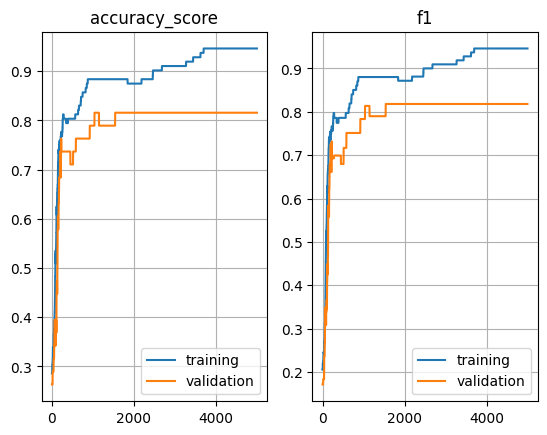

In [12]:
flower_classifier.plot_metrics()